In [1]:
import pandas as pd
import numpy as np

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras_preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

In [3]:
import os
import tensorflow as tf
import random
# fix the random seed for tensorflow models
os.environ['TF_DETERMINISTIC_OPS'] = '1' 
SEED = 39
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# set to use flexible GPU resources  
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [4]:
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}.")

Num GPUs Available: 1.


## Load data

In [5]:
text_data = pd.read_csv('./texts.csv')

text_data.head()

,Unnamed: 0,text,subject_id,hadm_id,mortality
0,0,sinus bradycardia av conduction delay qt inter...,67393,146953.0,0
1,1,baseline artifact sinus rhythm right bundle br...,9142,198248.0,1
2,2,atrial fibrillation possible flutter ventricul...,73608,162231.0,0
3,3,mobitz ii second degree av block nonconducted ...,29016,153345.0,0
4,4,sinus rhythm normal tracing previous tracing a...,12834,107726.0,0


In [6]:
X, y = text_data['text'], text_data['mortality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39, stratify=y)

In [24]:
X_train.shape

(26592,)

In [25]:
NUM_WORDS = 3000

# Tokenize the train text
train_text = X_train.to_numpy()

tokenizer = Tokenizer(
    num_words=NUM_WORDS, 
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
    lower=True,
    split=" ",
    char_level=False,
    oov_token='<unk>',
    document_count=0
)

tokenizer.fit_on_texts(train_text)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [26]:
MAX_LEN = 1000

train_seqs = tokenizer.texts_to_sequences(train_text)
train_seqs = keras.preprocessing.sequence.pad_sequences(train_seqs, maxlen=MAX_LEN, padding='post')

train_labels = y_train.to_numpy().flatten()

valid_text = X_test.to_numpy()
valid_seqs = tokenizer.texts_to_sequences(valid_text)
valid_seqs = keras.preprocessing.sequence.pad_sequences(valid_seqs, maxlen=MAX_LEN, padding='post')

valid_labels = y_test.to_numpy().flatten()

In [27]:
train_seqs

array([[ 879, 2144,  458, ..., 2290,  649,    1],
       [ 639,   98,   40, ...,  502,    1,    1],
       [ 103,   71,  104, ...,    0,    0,    0],
       ...,
       [1482,  560,  650, ..., 1798,    1,  153],
       [ 524,  106,  781, ...,  740,   99,  795],
       [ 103,   71,  293, ...,    0,    0,    0]], dtype=int32)

In [28]:
train_seqs.shape

# (30455, 606752) without preprocessing/limiting and truncating

(26592, 1000)

## LSTM model

In [29]:
# Method: For plotting the accuracy/loss of keras models
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [30]:
def SimpleClassifier(input_size):
    # Define the model structure - only LSTM layers
    inputs = keras.Input(input_size,)
    x = keras.layers.Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=input_size)(inputs)
    x = keras.layers.LSTM(64, activation='tanh')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    classifier = keras.Model(inputs, outputs)
    
    return classifier

In [31]:
classifier1 = SimpleClassifier(input_size=MAX_LEN)

optimizer1 = keras.optimizers.Adam(lr=0.0001)
classifier1.compile(optimizer=optimizer1, loss='binary_crossentropy', metrics=['accuracy'])

classifier1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 64)          192000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 225,345
Trainable params: 225,217
Non-trainable params: 128
_________________________________________________________________


In [32]:
# Define the early stopping criteria
early_stopping_accuracy1 = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
# reset_seeds()
classifier_history1 = classifier1.fit(train_seqs, 
          y_train, 
          epochs=50,
          batch_size=128,
          shuffle=True, 
          verbose=True, 
          validation_data=(valid_seqs, y_test),
          callbacks=[early_stopping_accuracy1])

Epoch 1/50
208/208 [==============================] - 15s 65ms/step - loss: 0.6689 - accuracy: 0.6080 - val_loss: 0.6110 - val_accuracy: 0.8615
Epoch 2/50
208/208 [==============================] - 13s 63ms/step - loss: 0.5670 - accuracy: 0.7633 - val_loss: 0.4732 - val_accuracy: 0.8634
Epoch 3/50
208/208 [==============================] - 13s 63ms/step - loss: 0.4754 - accuracy: 0.8565 - val_loss: 0.4392 - val_accuracy: 0.8767
Epoch 4/50
208/208 [==============================] - 13s 63ms/step - loss: 0.4010 - accuracy: 0.8787 - val_loss: 0.4029 - val_accuracy: 0.8625
Epoch 5/50
208/208 [==============================] - 13s 63ms/step - loss: 0.3446 - accuracy: 0.8934 - val_loss: 0.4095 - val_accuracy: 0.8499
Epoch 6/50
208/208 [==============================] - 13s 63ms/step - loss: 0.3052 - accuracy: 0.9024 - val_loss: 0.3301 - val_accuracy: 0.8816
Epoch 7/50
208/208 [==============================] - 13s 63ms/step - loss: 0.2885 - accuracy: 0.9031 - val_loss: 0.3406 - val_accuracy:

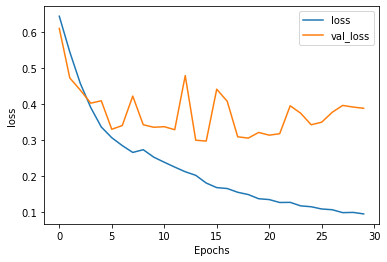

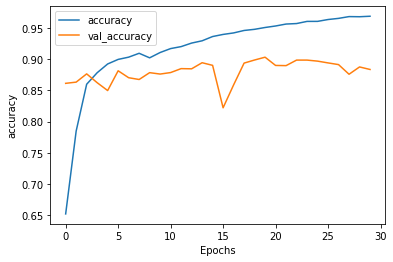

In [33]:
plot_graphs(classifier_history1, "loss")
plot_graphs(classifier_history1, "accuracy")

In [34]:
y_pred = classifier1.predict(valid_seqs)
y_pred_classes = np.array([1 if pred > 0.5 else 0 for pred in y_pred])

# classification report
acc = accuracy_score(y_true=y_test, y_pred=y_pred_classes)
print(acc)

confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true=y_test, y_pred=y_pred_classes, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
print(confusion_matrix_df)

print(classification_report(y_true=y_test, y_pred=y_pred_classes))

0.9034441269363814
          Pred:pos  Pred:neg
True:pos       366       555
True:neg        87      5641
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5728
           1       0.81      0.40      0.53       921

    accuracy                           0.90      6649
   macro avg       0.86      0.69      0.74      6649
weighted avg       0.90      0.90      0.89      6649



In [35]:
# Stack two or more LSTM layers
def Classifier(input_size):
    # Define the model structure - only LSTM layers
    inputs = keras.Input(input_size,)
    x = keras.layers.Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=input_size)(inputs)
    x = keras.layers.LSTM(64, activation='tanh', dropout=0.2, return_sequences=True)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LSTM(16, activation='tanh', dropout=0.2, return_sequences=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    classifier = keras.Model(inputs, outputs)
    
    return classifier

In [36]:
classifier2 = Classifier(input_size=MAX_LEN)

optimizer2 = keras.optimizers.Adam(lr=0.0001)
classifier2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])

classifier2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 64)          192000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 64)          33024     
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000, 64)          256       
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                5184      
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1088

In [37]:
# Define the early stopping criteria
early_stopping_accuracy2 = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True) # patient = 5 or 10 doesn't guarantee find an optimal

# Train the model
# reset_seeds()
classifier_history2 = classifier2.fit(train_seqs, 
          y_train, 
          epochs=50,
          batch_size=128,
          shuffle=True, 
          verbose=True, 
          validation_data=(valid_seqs, y_test),
          callbacks=[early_stopping_accuracy2])


Epoch 1/50
208/208 [==============================] - 22s 97ms/step - loss: 0.6536 - accuracy: 0.6249 - val_loss: 0.5876 - val_accuracy: 0.8615
Epoch 2/50
208/208 [==============================] - 20s 94ms/step - loss: 0.3889 - accuracy: 0.8635 - val_loss: 0.4172 - val_accuracy: 0.8633
Epoch 3/50
208/208 [==============================] - 20s 94ms/step - loss: 0.3538 - accuracy: 0.8722 - val_loss: 0.3618 - val_accuracy: 0.8701
Epoch 4/50
208/208 [==============================] - 20s 94ms/step - loss: 0.3283 - accuracy: 0.8811 - val_loss: 0.7972 - val_accuracy: 0.4235
Epoch 5/50
208/208 [==============================] - 20s 94ms/step - loss: 0.3023 - accuracy: 0.8885 - val_loss: 0.4298 - val_accuracy: 0.7791
Epoch 6/50
208/208 [==============================] - 21s 99ms/step - loss: 0.2854 - accuracy: 0.8974 - val_loss: 0.3942 - val_accuracy: 0.8079
Epoch 7/50
208/208 [==============================] - 21s 102ms/step - loss: 0.2651 - accuracy: 0.9059 - val_loss: 0.3211 - val_accuracy

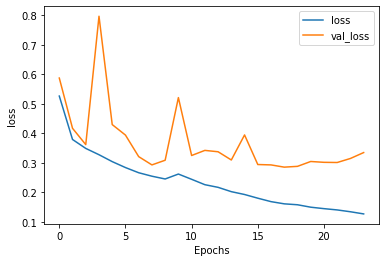

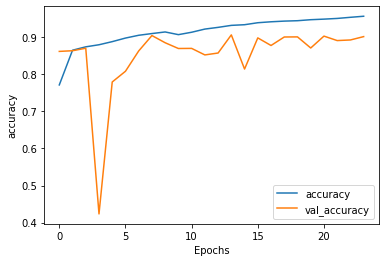

In [38]:
plot_graphs(classifier_history2, "loss")
plot_graphs(classifier_history2, "accuracy")

In [39]:
y_pred2 = classifier2.predict(valid_seqs)
y_pred_classes2 = np.array([1 if pred > 0.5 else 0 for pred in y_pred2])

# classification report
acc2 = accuracy_score(y_true=y_test, y_pred=y_pred_classes2)
print(acc2)

confusion_matrix_df2 = pd.DataFrame(
        confusion_matrix(y_true=y_test, y_pred=y_pred_classes2, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
print(confusion_matrix_df)

print(classification_report(y_true=y_test, y_pred=y_pred_classes2))

0.906000902391337
          Pred:pos  Pred:neg
True:pos       366       555
True:neg        87      5641
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5728
           1       0.81      0.42      0.55       921

    accuracy                           0.91      6649
   macro avg       0.86      0.70      0.75      6649
weighted avg       0.90      0.91      0.89      6649



In [40]:
from sklearn.metrics import balanced_accuracy_score
acc2 = balanced_accuracy_score(y_true=y_test, y_pred=y_pred_classes2)
print(acc2)


0.702154284115517
